## Importamos librerias

In [1]:
#EDA
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  

import numpy as np
import warnings
warnings.filterwarnings('ignore')

#Data viz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

#Modelos
import sklearn as sk
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

#Resultados
import shap

- CAMPAÑA: Año de la campaña.
- ID_FINCA: Identificador de finca.
- ID_ZONA: Identificador de una zona con una tipología de suelo común
- ID_ESTACION: Identificador de estación meteorológica.
- ALTITUD: Altitud media de la finca sobre el nivel del mar en metros.
- VARIEDAD: Código de variedad de la uva que se cultiva en la finca.
- MODO: Código del modo de cultivo.
- TIPO: Tipo de cultivo dentro de la variedad.
- COLOR: Identificador del color de la uva.
- SUPERFICIE: Superficie en hectáreas que ocupa la finca.
- PRODUCCION: Producción en kg. Obtenida en la campaña.

## Lectura de datos

In [2]:
df = pd.read_csv('C:/Users/denis/OneDrive/Escritorio/Datathon/datos/UH_2023_TRAIN.txt', sep= '|', header=0 )

In [3]:
df.columns = [col.lower().replace('-','_') for col in df.columns]

In [4]:
print(f'Número de filas: {df.shape[0]}, Número de columnas:{df.shape[1]}')
print(f'\nCantidad de duplicados: {df.duplicated().sum()}\n')
print('-------- Tipos de columnas --------')
print(df.dtypes)
print('\n -------- Cantidad de nulos --------')
df.isna().sum()

Número de filas: 9601, Número de columnas:11

Cantidad de duplicados: 0

-------- Tipos de columnas --------
campaña          int64
id_finca         int64
id_zona          int64
id_estacion      int64
altitud         object
variedad         int64
modo             int64
tipo             int64
color            int64
superficie     float64
produccion     float64
dtype: object

 -------- Cantidad de nulos --------


campaña           0
id_finca          0
id_zona           0
id_estacion       0
altitud          54
variedad          0
modo              0
tipo              0
color             0
superficie        0
produccion     1075
dtype: int64

## Transformaciones

**Altitud**

In [5]:
def transform_altitud(alt):
    if type(alt) is str:
        alt_list = alt.split("-")
        alt_list = list(map(float, alt_list))
        return np.mean(alt_list) 
    return alt

In [6]:
df['altitud'] = df['altitud'].apply(lambda alt: transform_altitud(alt))

In [7]:
df.describe()

,campaña,id_finca,id_zona,id_estacion,altitud,variedad,modo,tipo,color,superficie,produccion
count,9601.00,9601.00,9601.00,9601.00,9547.00,9601.00,9601.00,9601.00,9601.00,9601.00,8526.00
mean,17.94,50818.24,498.50,12.16,577.85,45.49,1.51,0.01,0.84,0.70,9209.19
std,2.61,29016.57,261.43,4.76,76.49,23.81,0.50,0.11,0.36,1.79,13268.81
min,14.00,200.00,7.00,0.00,370.00,4.00,1.00,0.00,0.00,0.00,0.72
25%,16.00,25104.00,284.00,7.00,490.00,17.00,1.00,0.00,1.00,0.00,1940.00
50%,18.00,50946.00,464.00,12.00,610.00,52.00,2.00,0.00,1.00,0.00,4620.00
75%,20.00,76361.00,726.00,16.00,635.00,59.00,2.00,0.00,1.00,0.56,11137.50
max,22.00,99793.00,990.00,19.00,820.00,94.00,2.00,1.00,1.00,26.85,177520.00


### Agrupacion de valores

Recategorizar aquellas columnas con muchos valores.

- Variedad
- Finca
- Altitud
- Zona

Hacerlo para **train**

In [8]:
df.nunique(axis=0)

campaña           9
id_finca       1231
id_zona         125
id_estacion      20
altitud          57
variedad         25
modo              2
tipo              2
color             2
superficie     1212
produccion     6287
dtype: int64

Separamos parte del dataset que utilizamos para imputaciones y nuevas features

- 2022 lo usamos para imputar, pero a la hora del modelo lo sacamos porque no tiene el Target
- Para los modelos usamos 2021 como Test, entonces lo sacamos ahora para las transformaciones para no hacer leakage -> Transf df
- Luego podemos hacer backtesting con 2020, tomando 2021.

Separamos 2021 arafue

In [9]:
transf = df[df.campaña != 21]

In [10]:
transf.isna().sum()

campaña           0
id_finca          0
id_zona           0
id_estacion       0
altitud          48
variedad          0
modo              0
tipo              0
color             0
superficie        0
produccion     1075
dtype: int64

**Variedad**

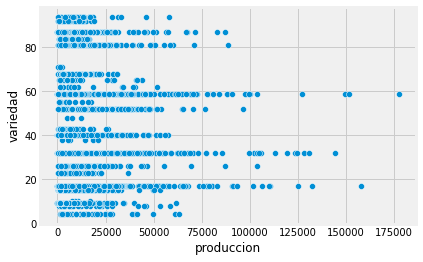

In [11]:
sns.scatterplot(data=df, x='produccion',y='variedad')
plt.show()

In [12]:
mayores = pd.DataFrame(transf.groupby('variedad')['produccion'].mean() > transf.produccion.mean())
mayores = list(mayores[mayores['produccion']].index)
df['variedad_alta'] = [1 if x in mayores else 0 for x in df.variedad]

In [13]:
df['variedad_alta'].value_counts()

0    7061
1    2540
Name: variedad_alta, dtype: int64

**Altitud**

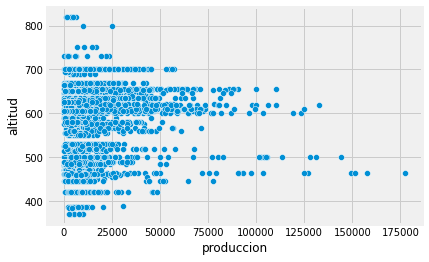

In [14]:
sns.scatterplot(data=df, x='produccion',y='altitud')
plt.show()

Arreglamos NAs

In [15]:
altitudes = pd.DataFrame(transf.groupby('id_estacion')['altitud'].mean()).reset_index() #Creamos DF con media de altura por estacion

df = df.merge(altitudes, how='left', on = 'id_estacion') #Joineamos con el df transformado
df['altitud'] = df.altitud_x.fillna(df.altitud_y) #Le pegamos la nueva altitud a los que tengan NA en la original
df = df.drop(columns=['altitud_x','altitud_y']) #Borramos columnas innecesarias
df.head()

,campaña,id_finca,id_zona,id_estacion,variedad,modo,tipo,color,superficie,produccion,variedad_alta,altitud
0,14,76953,515,4,26,2,0,1,0.00,22215.00,1,660.00
1,14,84318,515,4,26,2,0,1,0.00,22215.00,1,660.00
2,14,85579,340,4,32,2,0,1,0.00,20978.00,1,520.00
3,14,69671,340,4,32,2,0,1,0.00,40722.00,1,520.00
4,14,14001,852,14,81,1,0,1,0.00,14126.00,0,658.75


Altitud > media

In [16]:
mayores_altitud = pd.DataFrame(transf.groupby('altitud')['produccion'].mean() > transf.produccion.mean())
mayores_altitud = list(mayores_altitud[mayores_altitud['produccion']].index)
df['altitud_alta'] = [1 if x in mayores_altitud else 0 for x in df.altitud]

In [17]:
df['altitud_alta'].value_counts()

1    4970
0    4631
Name: altitud_alta, dtype: int64

**id_finca**

Calculamos percentiles y agregamos columna al df transf

In [18]:
fincas_prod = pd.DataFrame(transf.groupby('id_finca')['produccion'].mean()).reset_index()

In [19]:
Q1 = fincas_prod.produccion.quantile(0.25)
Q2 = fincas_prod.produccion.quantile(0.5)
Q3 = fincas_prod.produccion.quantile(0.75)

Q1,Q2,Q3

(1755.3360357142856, 3963.0299999999997, 8572.595238095239)

In [20]:
fincas_prod['fincas_percentiles'] = [0 if x < Q1 else 1 if x < Q2 else 2 if x < Q3 else 3 for x in fincas_prod.produccion]

In [21]:
df = df.merge(fincas_prod[['id_finca','fincas_percentiles']], how='left', on = 'id_finca') #Joineamos con el df transformado

In [22]:
df.fincas_percentiles.value_counts()

3.00    3328
2.00    2572
1.00    2183
0.00    1514
Name: fincas_percentiles, dtype: int64

**id_zona**

Misma metodologia

In [23]:
zonas_prod = pd.DataFrame(transf.groupby('id_zona')['produccion'].mean()).reset_index()

In [24]:
Q1 = zonas_prod.produccion.quantile(0.25)
Q2 = zonas_prod.produccion.quantile(0.5)
Q3 = zonas_prod.produccion.quantile(0.75)

Q1,Q2,Q3

(6090.485535714285, 9139.647419213978, 13569.882733333332)

In [25]:
zonas_prod['zonas_percentiles'] = [0 if x < Q1 else 1 if x < Q2 else 2 if x < Q3 else 3 for x in zonas_prod.produccion]

In [26]:
df = df.merge(zonas_prod[['id_zona','zonas_percentiles']], how='left', on = 'id_zona') #Joineamos con el df transformado

In [27]:
df.zonas_percentiles.value_counts()

0    2957
2    2877
1    2210
3    1557
Name: zonas_percentiles, dtype: int64

### Imputar NAs para superficie

- No usamos 2021 pues leakage, pero si usamos 2022

In [28]:
df['superficie'] = df['superficie'].replace(0, np.nan)
transf['superficie'] = transf['superficie'].replace(0, np.nan)

In [29]:
df.superficie.isna().sum()

6518

In [30]:
df.superficie.isna().groupby(df.campaña).sum()

campaña
14    1148
15    1116
16    1079
17    1017
18    1061
19    1055
20      13
21      20
22       9
Name: superficie, dtype: int64

Vamos cubriendo los NAs segun por menor a mayor jerarquia

In [31]:
superficies = pd.DataFrame(transf.groupby('id_finca')['superficie'].mean()).reset_index() #Creamos DF con media de altura por estacion

df = df.merge(superficies, how='left', on = 'id_finca') #Joineamos con el df transformado
df['superficie'] = df.superficie_x.fillna(df.superficie_y) #Le pegamos la nueva altitud a los que tengan NA en la original
df = df.drop(columns=['superficie_x','superficie_y']) #Borramos columnas innecesarias

In [32]:
superficies = pd.DataFrame(transf.groupby('id_zona')['superficie'].mean()).reset_index() #Creamos DF con media de altura por estacion

df = df.merge(superficies, how='left', on = 'id_zona') #Joineamos con el df transformado
df['superficie'] = df.superficie_x.fillna(df.superficie_y) #Le pegamos la nueva altitud a los que tengan NA en la original
df = df.drop(columns=['superficie_x','superficie_y']) #Borramos columnas innecesarias

In [33]:
superficies = pd.DataFrame(transf.groupby('id_estacion')['superficie'].mean()).reset_index() #Creamos DF con media de altura por estacion

df = df.merge(superficies, how='left', on = 'id_estacion') #Joineamos con el df transformado
df['superficie'] = df.superficie_x.fillna(df.superficie_y) #Le pegamos la nueva altitud a los que tengan NA en la original
df = df.drop(columns=['superficie_x','superficie_y']) #Borramos columnas innecesarias
df.head()

,campaña,id_finca,id_zona,id_estacion,variedad,modo,tipo,color,produccion,variedad_alta,altitud,altitud_alta,fincas_percentiles,zonas_percentiles,superficie
0,14,76953,515,4,26,2,0,1,22215.00,1,660.00,0,3.00,3,NaN
1,14,84318,515,4,26,2,0,1,22215.00,1,660.00,0,3.00,3,NaN
2,14,85579,340,4,32,2,0,1,20978.00,1,520.00,1,3.00,3,NaN
3,14,69671,340,4,32,2,0,1,40722.00,1,520.00,1,3.00,3,NaN
4,14,14001,852,14,81,1,0,1,14126.00,0,658.75,0,3.00,1,3.38


In [34]:
df['superficie'] = df.superficie.fillna(transf.superficie.mean())
df['superficie'].isna().sum()

0

Nos quedan 4 NAs en fincas_percentiles, hacemos fillna promedio

In [35]:
df['fincas_percentiles'] = df.fincas_percentiles.fillna(fincas_prod.fincas_percentiles.mean())

In [36]:
df.isna().sum()

campaña                  0
id_finca                 0
id_zona                  0
id_estacion              0
variedad                 0
modo                     0
tipo                     0
color                    0
produccion            1075
variedad_alta            0
altitud                  0
altitud_alta             0
fincas_percentiles       0
zonas_percentiles        0
superficie               0
dtype: int64

## Separamos train

- Sacamos 2022 y llamamos df_models al que le haremos split train y test
- El train contiene data desde el inicio hasta 2020
- El test, 2021

In [37]:
df_models = df[df.campaña < 22]

In [38]:
df_models.shape

(8526, 15)

In [39]:
df_models.isna().sum()

campaña               0
id_finca              0
id_zona               0
id_estacion           0
variedad              0
modo                  0
tipo                  0
color                 0
produccion            0
variedad_alta         0
altitud               0
altitud_alta          0
fincas_percentiles    0
zonas_percentiles     0
superficie            0
dtype: int64

In [40]:
cat_cols = ['id_finca', 'id_zona', 'id_estacion','variedad','modo','tipo','color']

label_encoder = LabelEncoder()

for var in cat_cols:
    df_models[var] = label_encoder.fit_transform(df_models[var])

df_models.head()

,campaña,id_finca,id_zona,id_estacion,variedad,modo,tipo,color,produccion,variedad_alta,altitud,altitud_alta,fincas_percentiles,zonas_percentiles,superficie
0,14,911,67,4,7,1,0,1,22215.00,1,660.00,0,3.00,3,2.17
1,14,993,67,4,7,1,0,1,22215.00,1,660.00,0,3.00,3,2.17
2,14,1014,39,4,8,1,0,1,20978.00,1,520.00,1,3.00,3,2.17
3,14,815,39,4,8,1,0,1,40722.00,1,520.00,1,3.00,3,2.17
4,14,171,107,14,20,0,0,1,14126.00,0,658.75,0,3.00,1,3.38


In [41]:
target = 'produccion'

X = df_models.loc[:, df_models.columns != target]
y = df_models[target]

X_train = X.iloc[:len(df_models[df_models['campaña']<21]),:]
X_test = X.iloc[len(df_models[df_models['campaña']<21]):,:]
y_train = y.iloc[:len(df_models[df_models['campaña']<21])]
y_test = y.iloc[len(df_models[df_models['campaña']<21]):]

In [42]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7482, 14), (1044, 14), (7482,), (1044,))

## Modelos

### Solo data train

In [43]:
%%time 

#Modelo
xgb = XGBRegressor(random_state=99)

#Entrenamiento
xgb.fit(X_train, y_train)

#Predicciones
prediction = xgb.predict(X_test)

#Resultados
mse = mean_squared_error(y_test, prediction)
print(np.sqrt(mse))

6241.497659419068
Wall time: 735 ms


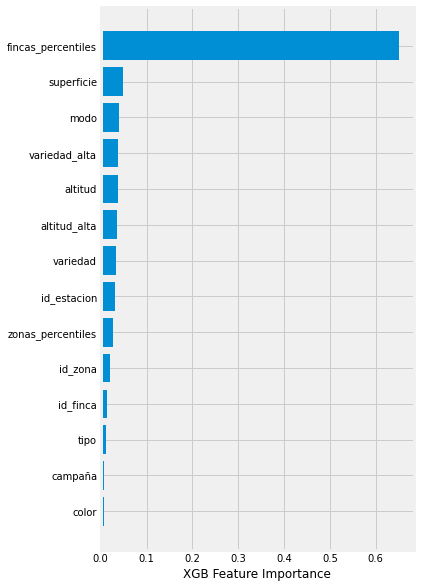

In [44]:
plt.figure(figsize=(5,10))

sorted_idx = xgb.feature_importances_.argsort()
plt.barh(y=X.columns[sorted_idx],width=xgb.feature_importances_[sorted_idx])
plt.xlabel("XGB Feature Importance")
plt.show()

### Cruzada con ETO

In [45]:
eto = pd.read_csv("C:/Users/denis/OneDrive/Escritorio/Datathon/datathon-cajamar-malbecs/data/processed/eto_processed.csv", index_col=0)
eto.head()

,ID_ESTACION,GustLocalDayAvg_1,GustLocalDayAvg_2,GustLocalDayAvg_3,GustLocalDayAvg_4,GustLocalDayAvg_5,GustLocalDayAvg_6,MSLPLocalDayAvg_1,MSLPLocalDayAvg_2,MSLPLocalDayAvg_3,MSLPLocalDayAvg_4,MSLPLocalDayAvg_5,MSLPLocalDayAvg_6,RelativeHumidityLocalDayAvg_1,RelativeHumidityLocalDayAvg_2,RelativeHumidityLocalDayAvg_3,RelativeHumidityLocalDayAvg_4,RelativeHumidityLocalDayAvg_5,RelativeHumidityLocalDayAvg_6,UVIndexLocalDayAvg_1,UVIndexLocalDayAvg_2,UVIndexLocalDayAvg_3,UVIndexLocalDayAvg_4,UVIndexLocalDayAvg_5,UVIndexLocalDayAvg_6,VisibilityLocalDayAvg_1,VisibilityLocalDayAvg_2,VisibilityLocalDayAvg_3,VisibilityLocalDayAvg_4,VisibilityLocalDayAvg_5,VisibilityLocalDayAvg_6,WindSpeedLocalDayAvg_1,WindSpeedLocalDayAvg_2,WindSpeedLocalDayAvg_3,WindSpeedLocalDayAvg_4,WindSpeedLocalDayAvg_5,WindSpeedLocalDayAvg_6,lluvia_daytime_avg_1,lluvia_daytime_avg_2,lluvia_daytime_avg_3,lluvia_daytime_avg_4,lluvia_daytime_avg_5,lluvia_daytime_avg_6,lluvia_night_avg_1,lluvia_night_avg_2,lluvia_night_avg_3,lluvia_night_avg_4,lluvia_night_avg_5,lluvia_night_avg_6,nieve_daytime_Avg_1,nieve_daytime_Avg_2,nieve_daytime_Avg_3,nieve_daytime_Avg_4,nieve_daytime_Avg_5,nieve_daytime_Avg_6,nieve_night_Avg_1,nieve_night_Avg_2,nieve_night_Avg_3,nieve_night_Avg_4,nieve_night_Avg_5,nieve_night_Avg_6,campaña
0,0,8.73,8.81,8.41,8.09,8.11,5.90,102201.83,102146.62,101755.81,101428.21,101617.30,101532.45,67.64,66.56,68.41,70.65,61.86,42.60,0.40,0.62,1.04,1.54,2.13,1.45,12703.95,12566.77,12205.02,12427.89,13459.72,16093.00,2.80,2.68,3.10,2.66,2.34,3.35,40.80,12.51,55.03,45.26,20.23,0.00,33.60,9.94,41.66,54.51,11.83,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,15
1,1,9.46,8.96,8.78,8.50,8.58,6.25,102234.06,102167.03,101762.08,101431.50,101629.07,101553.19,72.75,69.21,69.56,70.14,59.82,36.65,0.40,0.63,1.04,1.55,2.14,1.60,12317.72,12307.27,12143.72,12397.98,13268.26,16093.00,3.81,3.63,4.09,3.53,3.13,3.85,25.54,11.31,42.86,44.23,23.66,0.00,16.63,10.11,35.83,51.94,24.51,0.00,0.06,0.01,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,15
2,2,9.01,8.94,8.49,8.27,8.05,0.00,102230.35,102165.75,101763.44,101439.95,101615.43,101532.84,69.86,66.95,67.13,68.15,59.89,41.05,0.42,0.64,1.07,1.58,2.17,1.50,12708.40,12722.14,12670.05,12872.93,13692.44,16093.00,2.97,2.84,3.23,2.88,2.62,3.35,20.74,5.14,43.03,38.91,14.06,0.00,19.20,3.43,31.20,46.11,17.66,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,15
3,3,9.29,9.06,8.66,8.48,8.16,6.30,102213.03,102157.90,101758.68,101429.61,101625.83,101547.07,71.02,69.21,70.03,71.44,62.10,38.90,0.40,0.62,1.04,1.54,2.14,1.50,12500.75,12391.16,12075.28,12384.46,13293.40,16093.00,3.61,3.43,3.89,3.33,2.91,3.65,31.54,8.74,44.74,35.49,16.97,0.00,25.89,8.23,38.06,43.03,16.11,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,15
4,4,9.37,9.01,8.65,8.43,8.25,6.00,102229.53,102164.91,101770.68,101446.43,101620.98,101541.87,70.35,67.81,68.13,68.75,59.33,37.10,0.41,0.63,1.06,1.56,2.15,1.50,12605.38,12518.67,12333.94,12669.56,13506.27,16093.00,3.79,3.57,4.05,3.50,3.06,3.85,22.80,7.54,45.26,37.37,12.00,0.00,18.51,8.91,37.54,43.54,23.83,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,15


In [46]:
eto.columns = [col.lower().replace('-','_') for col in eto.columns]

In [47]:
df_join = pd.merge(df, eto, on=['id_estacion', 'campaña'])

In [48]:
df_models = df_join[df_join.campaña < 22]

target = 'produccion'

X = df_models.loc[:, df_models.columns != target]
y = df_models[target]

X_train = X.iloc[:len(df_models[df_models['campaña']<21]),:]
X_test = X.iloc[len(df_models[df_models['campaña']<21]):,:]
y_train = y.iloc[:len(df_models[df_models['campaña']<21])]
y_test = y.iloc[len(df_models[df_models['campaña']<21]):]

In [49]:
%%time 

#Modelo
xgb = XGBRegressor(random_state=99)

#Entrenamiento
xgb.fit(X_train, y_train)

#Predicciones
prediction = xgb.predict(X_test)

#Resultados
mse = mean_squared_error(y_test, prediction)
print(np.sqrt(mse))

7706.834210928002
Wall time: 1.38 s


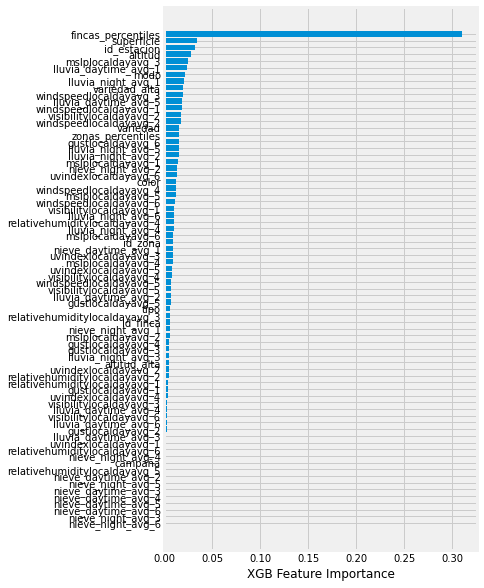

In [50]:
plt.figure(figsize=(5,10))

sorted_idx = xgb.feature_importances_.argsort()
plt.barh(y=X.columns[sorted_idx],width=xgb.feature_importances_[sorted_idx])
plt.xlabel("XGB Feature Importance")
plt.show()

### Con ETO anuales

In [51]:
gust = ['gustlocaldayavg_1', 'gustlocaldayavg_2', 'gustlocaldayavg_3',
       'gustlocaldayavg_4', 'gustlocaldayavg_5', 'gustlocaldayavg_6']

mslp = ['mslplocaldayavg_1', 'mslplocaldayavg_2', 'mslplocaldayavg_3',
       'mslplocaldayavg_4', 'mslplocaldayavg_5', 'mslplocaldayavg_6']

relative = ['relativehumiditylocaldayavg_1', 'relativehumiditylocaldayavg_2',
       'relativehumiditylocaldayavg_3', 'relativehumiditylocaldayavg_4',
       'relativehumiditylocaldayavg_5', 'relativehumiditylocaldayavg_6']

uv = ['uvindexlocaldayavg_1', 'uvindexlocaldayavg_2', 'uvindexlocaldayavg_3',
       'uvindexlocaldayavg_4', 'uvindexlocaldayavg_5', 'uvindexlocaldayavg_6']

visibility = [ 'visibilitylocaldayavg_1', 'visibilitylocaldayavg_2',
       'visibilitylocaldayavg_3', 'visibilitylocaldayavg_4',
       'visibilitylocaldayavg_5', 'visibilitylocaldayavg_6']

wind = ['windspeedlocaldayavg_1', 'windspeedlocaldayavg_2',
       'windspeedlocaldayavg_3', 'windspeedlocaldayavg_4',
       'windspeedlocaldayavg_5', 'windspeedlocaldayavg_6']

lluvia_day = ['lluvia_daytime_avg_1', 'lluvia_daytime_avg_2', 'lluvia_daytime_avg_3',
       'lluvia_daytime_avg_4', 'lluvia_daytime_avg_5', 'lluvia_daytime_avg_6']

lluvia_night = ['lluvia_night_avg_1', 'lluvia_night_avg_2', 'lluvia_night_avg_3',
       'lluvia_night_avg_4', 'lluvia_night_avg_5', 'lluvia_night_avg_6']

nieve_day = ['nieve_daytime_avg_1', 'nieve_daytime_avg_2', 'nieve_daytime_avg_3',
       'nieve_daytime_avg_4', 'nieve_daytime_avg_5', 'nieve_daytime_avg_6']

nieve_night = ['nieve_night_avg_1', 'nieve_night_avg_2', 'nieve_night_avg_3',
       'nieve_night_avg_4', 'nieve_night_avg_5', 'nieve_night_avg_6']


In [52]:
df_models2 = df_models.copy()

In [53]:
list_data = {'gust': gust, 'mslp': mslp,'relative': relative, 'uv': uv,'visibility': visibility,
              'wind': wind,'lluvia_day': lluvia_day, 'lluvia_night': lluvia_night,'nieve_day': nieve_day, 'nieve_night': nieve_night}

for name, data in list_data.items():
    df_models2[name] = df_models2[data].sum(axis=1)
    df_models2 = df_models2.drop(columns=data)

In [54]:
df_models2.head()

,campaña,id_finca,id_zona,id_estacion,variedad,modo,tipo,color,produccion,variedad_alta,altitud,altitud_alta,fincas_percentiles,zonas_percentiles,superficie,gust,mslp,relative,uv,visibility,wind,lluvia_day,lluvia_night,nieve_day,nieve_night
0,15,48626,302,13,32,2,0,1,27966.00,1,600.00,0,3.00,3,3.75,49.35,610766.39,376.14,7.29,79449.71,20.85,125.49,124.11,0.04,0.02
1,15,47921,302,13,32,2,0,1,65254.00,1,600.00,0,3.00,3,7.37,49.35,610766.39,376.14,7.29,79449.71,20.85,125.49,124.11,0.04,0.02
2,15,14001,852,14,81,1,0,1,7470.80,0,658.75,0,3.00,1,3.38,49.93,610740.95,383.11,7.25,78643.24,21.15,133.71,128.91,0.07,0.03
3,15,17059,852,14,81,1,0,1,5898.00,0,658.75,0,2.00,1,3.38,49.93,610740.95,383.11,7.25,78643.24,21.15,133.71,128.91,0.07,0.03
4,15,87611,602,14,81,1,0,1,6810.00,0,658.75,0,3.00,2,3.38,49.93,610740.95,383.11,7.25,78643.24,21.15,133.71,128.91,0.07,0.03


In [55]:
target = 'produccion'

X = df_models2.loc[:, df_models2.columns != target]
y = df_models2[target]

X_train = X.iloc[:len(df_models2[df_models2['campaña']<21]),:]
X_test = X.iloc[len(df_models2[df_models2['campaña']<21]):,:]
y_train = y.iloc[:len(df_models2[df_models2['campaña']<21])]
y_test = y.iloc[len(df_models2[df_models2['campaña']<21]):]

In [56]:
%%time 

#Modelo
xgb = XGBRegressor(random_state=99)

#Entrenamiento
xgb.fit(X_train, y_train)

#Predicciones
prediction = xgb.predict(X_test)

#Resultados
mse = mean_squared_error(y_test, prediction)
print(np.sqrt(mse))

6470.549443410535
Wall time: 666 ms


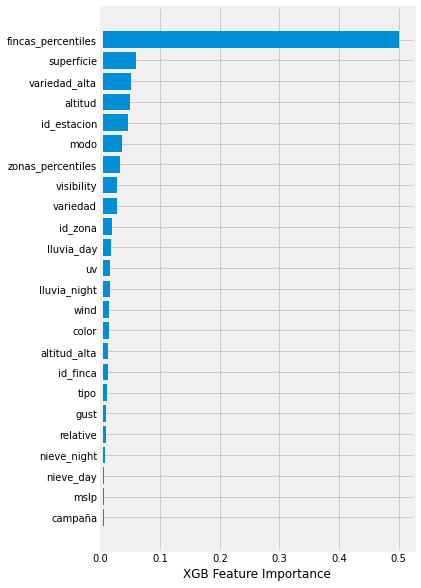

In [57]:
plt.figure(figsize=(5,10))

sorted_idx = xgb.feature_importances_.argsort()
plt.barh(y=X.columns[sorted_idx],width=xgb.feature_importances_[sorted_idx])
plt.xlabel("XGB Feature Importance")
plt.show()